# Question Answering

Como hemos visto en la teoría, la arquitectura de para un question answering consiste en un módulo de generación que se implementa con un LLM. Vamos a construir dos modelos que generen respuestas a ciertas preguntas, y vamos a analizar el impacto de introducir cierto contexto a la pregunta.






## Generadores de respuestas

In [12]:
# Descomentar la siguiente linea en Google Collab
#!pip install transformers datasets rouge-score nltk scikit-learn matplotlib
device_setup=None # cambiar esto a "auto" en Google collab
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # set to true in GoogleCollab

In [13]:
from huggingface_hub import login
token = ""
print("Hugging Face logging")
login(token)

Hugging Face logging


### LLMs como generadores

In [15]:
import torch
from transformers import pipeline
import warnings
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

warnings.filterwarnings("ignore", category=UserWarning, module="transformers.pytorch_utils")

class LLMModel:

    def __init__(self, model_name="tinyllama", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", use_context=False):
        global device_setup
        self.model_name = model_name
        self.use_context = use_context
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModelForCausalLM.from_pretrained(
            model,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,  # Configuración dinámica de precisión
            device_map=device_setup,
            cache_dir="./models/" + self.model_name,
            local_files_only=False
        )

    def __answer_with_model(self, prompt, do_sample, temperature, top_p, max_length, num_return_sequences, show_prompt):
        formatted_promt = self.tokenizer.apply_chat_template(conversation=prompt, tokenize=False, return_dict=False, continue_final_message=True)
        # TODO: have a look at the formatted_promt
        if show_prompt:
          print(formatted_promt)
          print("------",len(formatted_promt),"-------")
        # Tokenizar
        inputs = self.tokenizer(formatted_promt, truncation=True, max_length=max_length,return_tensors="pt")
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Generar respuesta
        outputs = self.model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            temperature=temperature,
            top_p=top_p,
            do_sample=do_sample,
            pad_token_id=self.tokenizer.eos_token_id
        )

        # Decodificar y limpiar respuesta
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Limpiar la respuesta para que no aparezca el prompt
        clean_response = response[len(formatted_promt)-1:].strip()
        if len(clean_response)==0:
          clean_response = 'I do not know'
        response = clean_response.split(":")[1] if ":" in clean_response else clean_response
        return response

    def __get_nocontext_prompt(self, query):
        return [
            {
                "role": "system",
                "content": "Give a comprehensive answer to the question. Respond only to the question asked, response should be concise and relevant to the question.",
            },
            {"role": "user", "content": "Question: " + query + "\nAnswer:"},
        ]

    def __get_context_prompt(self, query, context=""):
        context = "" if not context else context
        return [{
            "role": "system",
            "content": "Use the following context to answer the question concisely and accurately. If the answer cannot be deduced from the context, do not answer the question and just say 'I do not know'.",
        },
        {"role": "user", "content": "Context:\n"+'\n'.join(context)+"\nQuestion: "+query+"\nAnswer:"}
    ]

    def answer(self, query, context, use_context=False, do_sample=True, temperature=0.7,
               top_p=0.9, max_length=2048, num_return_sequences=1, show_prompt=False):
        prompt = self.__get_context_prompt(query,
                                           context) if use_context or self.use_context else self.__get_nocontext_prompt(
            query)
        return self.__answer_with_model(prompt, do_sample, temperature, top_p, max_length, num_return_sequences, show_prompt)



In [ ]:
# https://huggingface.co/datasets/rag-datasets/rag-mini-wikipedia
models = [
    ("TinyLlama-1-NC", LLMModel(use_context=False, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-nc")),
    ("TinyLlama-2-C", LLMModel(use_context=True, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-c"))
]
context = [
    "Abraham Lincoln (February 12, 1809 – April 15, 1865) was the 16th president of the United States, serving from 1861 until his assassination in 1865. He led the United States through the American Civil War, defending the nation as a constitutional union, defeating the Confederacy, playing a major role in the abolition of slavery, expanding the power of the federal government, and modernizing the U.S. economy."
    ]

queries = ["Was Abraham Lincoln the sixteenth President of the United States?", "Did Lincoln sign the National Banking Act of 1863?"]
for query in queries:
    for model_name, model in models:
        # Generar respuesta del modelo
        answer = model.answer(query=query, context=context, do_sample=False, temperature=1.0, num_return_sequences=1)
        print(">", model_name, ": ", answer)
        print("**********")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "covidqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 1:
        break

models = [
    ("TinyLlama-1-NC", LLMModel(use_context=False, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-nc")),
    ("TinyLlama-2-C", LLMModel(use_context=True, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-c"))
]

for raw_row in dataset:
  print("query: ", raw_row['question'])
  print("expected: ", raw_row['answer'])
  print("--------------------")
  for model_name, model in models:
    answer = model.answer(query=raw_row['question'], context=raw_row['documents'], do_sample=False, max_length=2048, show_prompt=True)
    print("\t>", model_name, ": ", answer)
    print("**********")
  print("#######################")


### Evaluar sistemas de question answering

1. Exact Match (EM)
Qué mide: Si la respuesta generada coincide exactamente con el gold standard.
Ventaja: Es fácil de interpretar.
Desventaja: Es muy estricta, ya que no considera sinónimos, parafraseos o respuestas parcialmente correctas.
Ejemplo:
Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President of the United States."
Gold Standard: "Yes"
Resultado: No hay match exacto.
2. F1-Score
Qué mide: La similitud entre las palabras de la respuesta generada y las del gold standard en términos de precisión y recall.
Precisión: Proporción de palabras generadas que son correctas.
Recall: Proporción de palabras correctas del gold standard capturadas en la respuesta.
Ventaja: Tolera parafraseos y respuestas parciales.
Desventaja: Ignora el orden de las palabras.
Ejemplo:
Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President."
Gold Standard: "Yes"
Resultado: Precisión alta, pero recall puede ser bajo.
3. BLEU (Bilingual Evaluation Understudy)
Qué mide: Coincidencias en n-gramas entre la respuesta generada y el gold standard.
Evalúa secuencias de palabras en lugar de palabras individuales.
Ventaja: Considera el orden de las palabras.
Desventaja: Fue diseñado para traducción, no QA; no siempre captura la calidad semántica.
Ejemplo:
Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President of the United States."
Gold Standard: "Yes"
Resultado: BLEU bajo debido a pocas coincidencias en n-gramas.
4. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
Qué mide: Coincidencias de n-gramas y recall.
Variantes populares:
ROUGE-1: Coincidencias de palabras.
ROUGE-2: Coincidencias de bi-gramas.
ROUGE-L: Coincidencias en la subsecuencia común más larga (longest common subsequence).
Ventaja: Útil para evaluar respuestas más largas o con paráfrasis.
Desventaja: No mide la semántica.
Ejemplo:
Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President."
Gold Standard: "Yes"
Resultado: ROUGE-1 puede ser alto, pero ROUGE-2 bajo.
5. METEOR (Metric for Evaluation of Translation with Explicit ORdering)
Qué mide: Coincidencias en palabras exactas, sinónimos y orden de palabras.
Incluye aspectos de precisión, recall y alineación de palabras.
Ventaja: Captura variaciones léxicas como sinónimos.
Desventaja: No siempre refleja la semántica general.
Ejemplo:
Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President."
Gold Standard: "Yes"
Resultado: METEOR considera las palabras coincidentes y podría ser razonablemente alto.
6. Cosine Similarity (TF-IDF o Embeddings)
Qué mide: Similitud semántica entre la respuesta generada y el gold standard.
Usa representaciones vectoriales de los textos.
Ventaja: Evalúa el significado general más allá de palabras exactas.
Desventaja: Puede ser insensible a detalles específicos como el formato de la respuesta.
Ejemplo:
Respuesta modelo: "Yes, Abraham Lincoln was the sixteenth President of the United States."
Gold Standard: "Yes"
Resultado: Alta similitud si los vectores semánticos son similares.

In [16]:
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
import nltk
nltk.download('wordnet')

def evaluate_qa_system(models, dataset):
    results_by_model = {}

    # Métricas y helpers
    vectorizer = TfidfVectorizer()
    rouge_scorer_obj = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    for model_name, model in models:
        metrics = {
            "bleu": [],
            "rouge": {"rouge1": [], "rouge2": [], "rougeL": []},
            "meteor": [],
            "exact_match": [],
            "f1": [],
            "cosine_similarity": []
        }

        for entry in dataset:
            query = entry["question"]
            context = entry["documents"]
            ground_truth = entry["answer"]

            # Respuesta del modelo
            prediction = model.answer(query=query, context=context, do_sample=False, max_length=2048)

            # BLEU
            bleu_score = sentence_bleu([ground_truth.split()], prediction.split())
            metrics["bleu"].append(bleu_score)

            # ROUGE
            rouge_scores = rouge_scorer_obj.score(ground_truth, prediction)
            for rouge_metric in ["rouge1", "rouge2", "rougeL"]:
                metrics["rouge"][rouge_metric].append(rouge_scores[rouge_metric].fmeasure)

            # METEOR
            meteor = meteor_score([ground_truth.split()], prediction.split())
            metrics["meteor"].append(meteor)

            # Exact Match
            exact_match = int(prediction.strip() == ground_truth.strip())
            metrics["exact_match"].append(exact_match)

            # F1 Score
            y_true = set(ground_truth.split())
            y_pred = set(prediction.split())
            common = y_true & y_pred
            precision = len(common) / len(y_pred) if y_pred else 0
            recall = len(common) / len(y_true) if y_true else 0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
            metrics["f1"].append(f1)

            # Cosine Similarity
            tfidf_matrix = vectorizer.fit_transform([ground_truth, prediction])
            cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            metrics["cosine_similarity"].append(cosine_sim)

        # Promediar resultados
        avg_metrics = {
            "bleu": np.mean(metrics["bleu"]),
            "rouge": {k: np.mean(v) for k, v in metrics["rouge"].items()},
            "meteor": np.mean(metrics["meteor"]),
            "exact_match": np.mean(metrics["exact_match"]),
            "f1": np.mean(metrics["f1"]),
            "cosine_similarity": np.mean(metrics["cosine_similarity"])
        }
        results_by_model[model_name] = avg_metrics

    return results_by_model

def plot_evaluation_results(results_by_model):
    metrics = ["bleu", "meteor", "exact_match", "f1", "cosine_similarity"]
    models = list(results_by_model.keys())

    for metric in metrics:
        values = [results_by_model[model][metric] for model in models]
        plt.figure()
        plt.bar(models, values)
        plt.title(f"Comparación de {metric.capitalize()}")
        plt.xlabel("Modelos")
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Evaluación con basada en benchmark

/Users/andreacimmino/Desktop/UEX/curso-pln/aplicaciones/question_answering/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/andreacimmino/Desktop/UEX/curso-pln/aplicaciones/question_answering/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Users/andreacimmino/Desktop/UEX/curso-pln/aplicaciones/question_answering/.venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, inde

Resultados para  TinyLlama-1-NC
bleu :  0.0146879669332504
rouge :  {'rouge1': 0.2936362610952947, 'rouge2': 0.13050401074390555, 'rougeL': 0.25110760148330175}
meteor :  0.21216241112600995
exact_match :  0.0
f1 :  0.24991140248377852
cosine_similarity :  0.2720234277795609
Resultados para  TinyLlama-2-C
bleu :  0.11296381019514537
rouge :  {'rouge1': 0.35975811030342325, 'rouge2': 0.23392511444411887, 'rougeL': 0.30625742898848546}
meteor :  0.30910925583134197
exact_match :  0.0
f1 :  0.30464583258045597
cosine_similarity :  0.3118531216526431


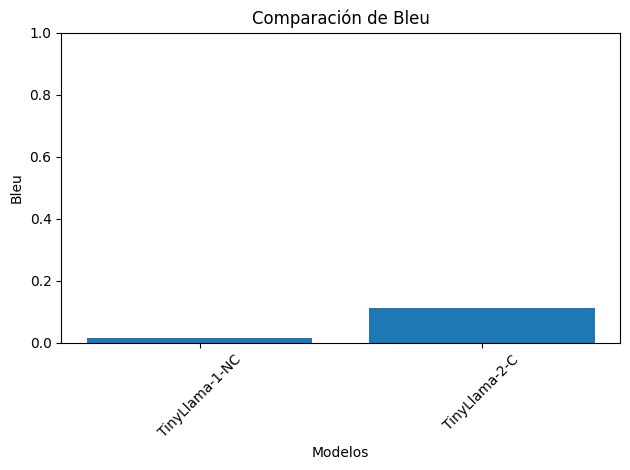

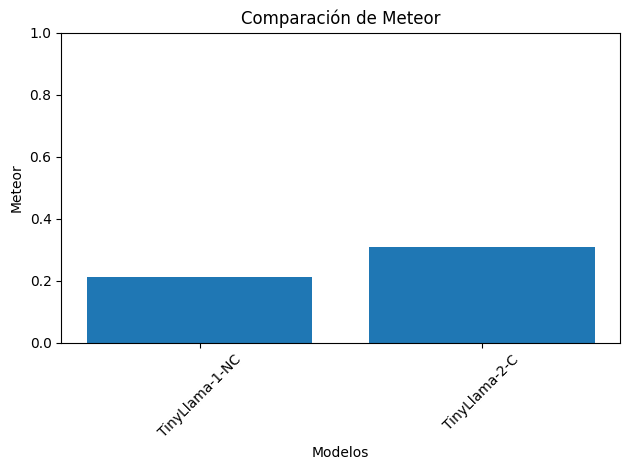

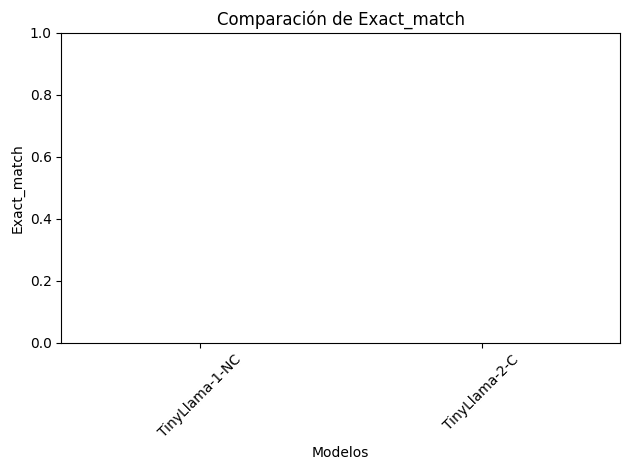

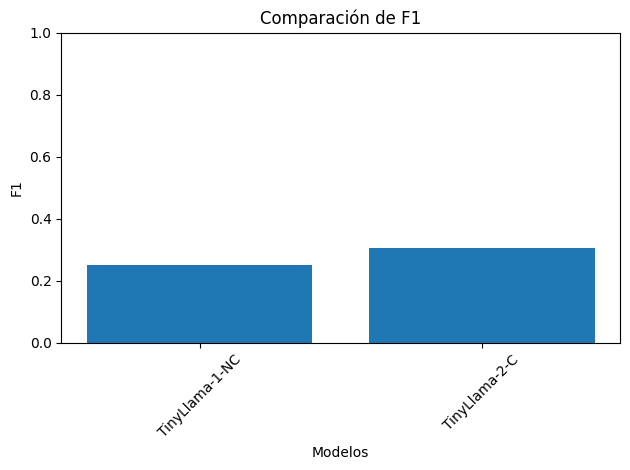

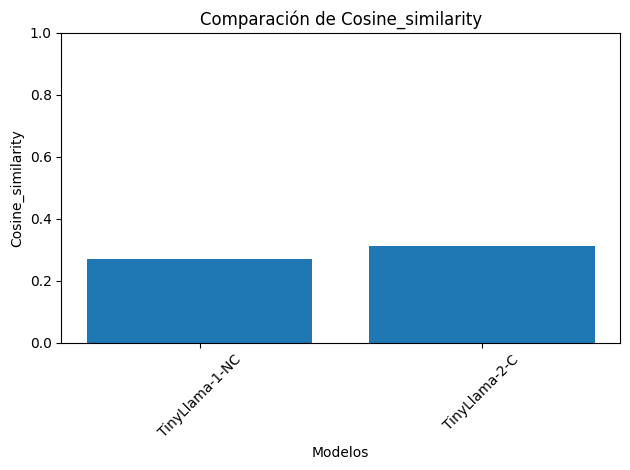

In [7]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "covidqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 10:
        break


models = [
    ("TinyLlama-1-NC", LLMModel(use_context=False, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-nc")),
    ("TinyLlama-2-C", LLMModel(use_context=True, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-c"))
]


results_by_model = evaluate_qa_system(models, dataset)


# Mostrar resultados
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Graficar resultados
plot_evaluation_results(results_by_model)

In [17]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "delucionqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 10:
        break


models = [
    ("TinyLlama-1-NC", LLMModel(use_context=False, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-nc")),
    ("TinyLlama-2-C", LLMModel(use_context=True, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-c"))
]


results_by_model = evaluate_qa_system(models, dataset)


# Mostrar resultados
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Graficar resultados
plot_evaluation_results(results_by_model)

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1.
403 Client Error. (Request ID: Root=1-6772e8dc-245ea6c415fc533038405e8d;933ccd03-6868-458a-808b-54b55d33bc10)

Cannot access gated repo for url https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1/resolve/main/config.json.
Access to model mistralai/Mixtral-8x7B-Instruct-v0.1 is restricted and you are not in the authorized list. Visit https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1 to ask for access.

Resultados para  TinyLlama-1-NC
bleu :  0.18826990965953655
rouge :  {'rouge1': 0.41538947947495036, 'rouge2': 0.37362082068289304, 'rougeL': 0.40527648512466785}
meteor :  0.3531183192639657
exact_match :  0.0
f1 :  0.41060256930507855
cosine_similarity :  0.4596509026884553
Resultados para  TinyLlama-2-C
bleu :  0.1783351982062325
rouge :  {'rouge1': 0.4476419860209777, 'rouge2': 0.39371039094691057, 'rougeL': 0.43752899167069526}
meteor :  0.3489400690460544
exact_match :  0.0
f1 :  0.3991548138744038
cosine_similarity :  0.5070985198995555


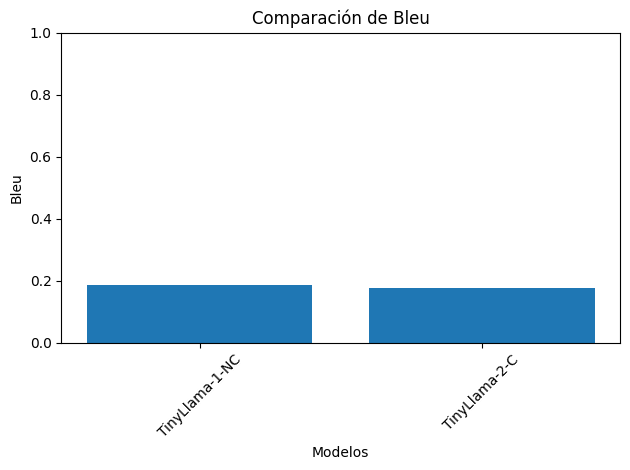

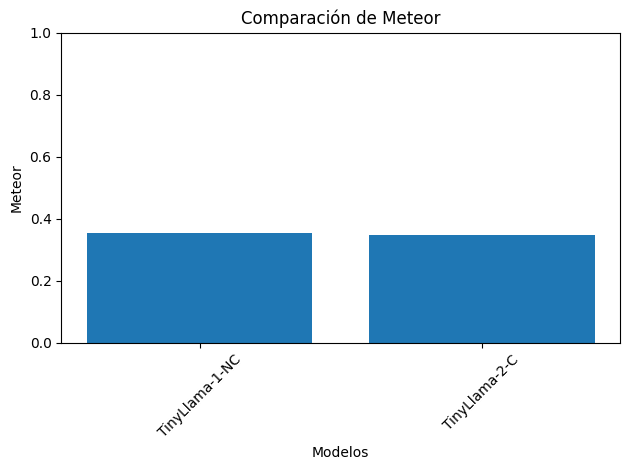

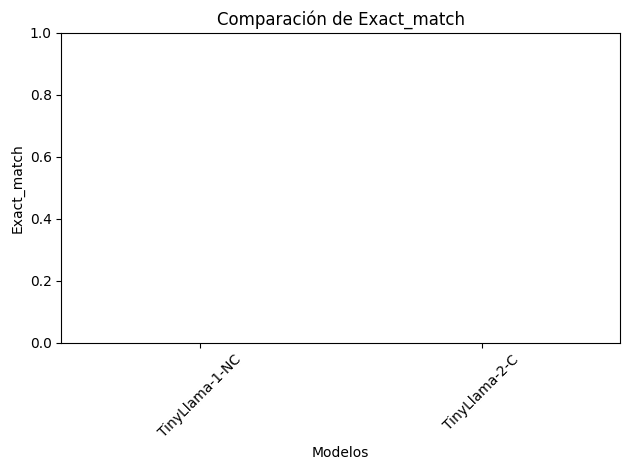

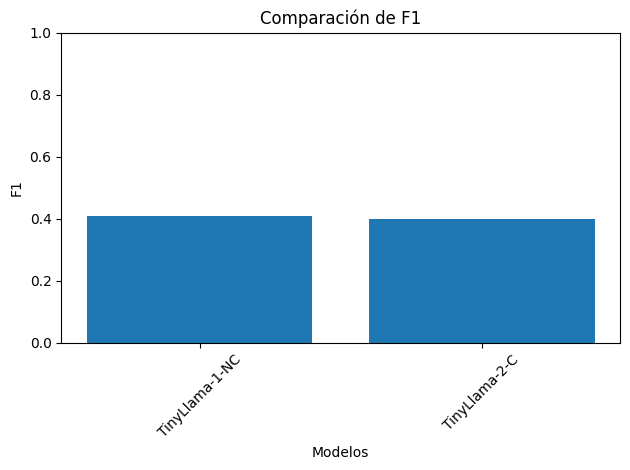

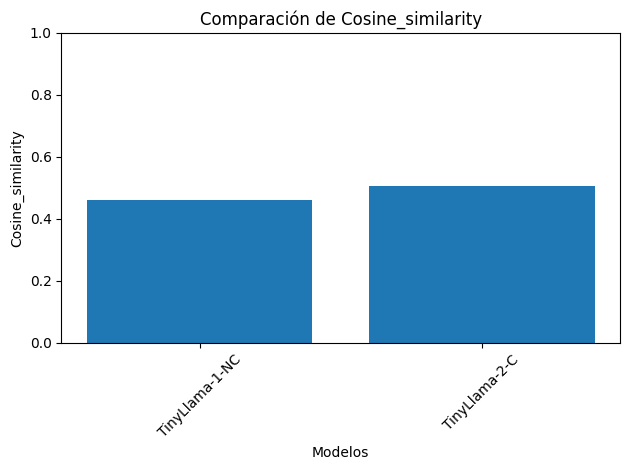

In [10]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench= load_dataset("rungalileo/ragbench", "finqa", split=["test"])

dataset = []
index = 0
for ds_row in ragbench[0]:
    dataset.append({"question" : ds_row["question"], "documents" : ds_row["documents"], "answer" : ds_row["response"] })
    index += 1
    if index == 10:
        break


models = [
    ("TinyLlama-1-NC", LLMModel(use_context=False, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-nc")),
    ("TinyLlama-2-C", LLMModel(use_context=True, model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", model_name="llama-c"))
]


results_by_model = evaluate_qa_system(models, dataset)


# Mostrar resultados
for model_name, metrics in results_by_model.items():
    print("Resultados para ",model_name)
    for metric, value in metrics.items():
        print(metric,": ",value)

# Graficar resultados
plot_evaluation_results(results_by_model)